In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations

# MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop

In [7]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

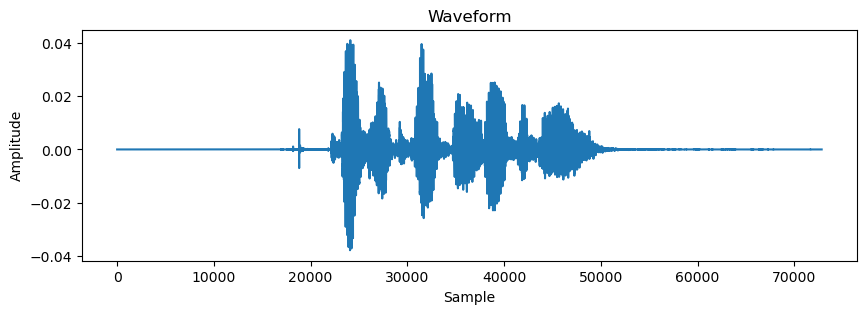

In [8]:
import librosa
import matplotlib.pyplot as plt

# Specify the audio file path
audio_file = 'ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav'

# Load audio data
data, sampling_rate = librosa.load(audio_file)

# Create the plot
plt.figure(figsize=(10, 3))
plt.plot(data)  # Plot the waveform

# Add labels and title
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')

# Display the plot
plt.show()


C:\Users\nvgop\AppData\Local\Temp\ipykernel_9136\2012999026.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav')
C:\Users\nvgop\AppData\Local\Temp\ipykernel_9136\2012999026.py:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


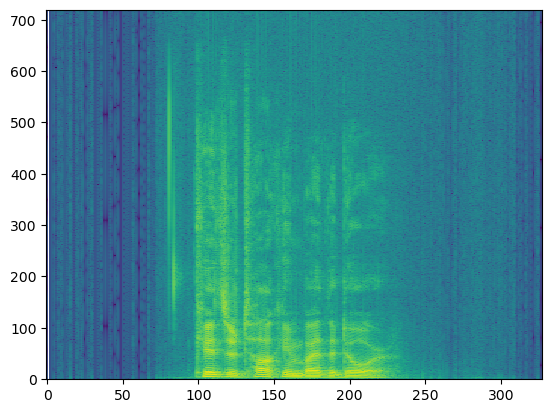

In [9]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [10]:
##### load radvess speech data #####
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
for dirname, _, filenames in os.walk('ravdess-emotional-speech-audio'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        radvess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
        wav_file_name = os.path.join(dirname, filename)
        ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [11]:
#### convert data and label to array ravdess-emotional-speech-audio
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
labels_categorical.shape

(2880, 8)

In [12]:
ravdess_speech_data_array.shape

(2880, 40)

In [13]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),labels_categorical, test_size=0.20, random_state=9)

In [14]:
# Split the training, validating, and testing sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [15]:
# Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [16]:
# Create the model
model_LSTM = create_model_LSTM()

# Get the summary of the model
model_LSTM.summary()

c:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,160 (301.41 KB)

 Trainable params: 77,160 (301.41 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
w = np.expand_dims(ravdess_speech_data_array[:training_samples],-1)

In [18]:
w.shape

(2304, 40, 1)

In [19]:
### train using LSTM model
model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), 
epochs=200, shuffle=True)

Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1356 - loss: 2.0840 - val_accuracy: 0.2257 - val_loss: 2.0391
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1934 - loss: 2.0358 - val_accuracy: 0.2917 - val_loss: 1.9505
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2112 - loss: 1.9973 - val_accuracy: 0.2778 - val_loss: 1.9194
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2125 - loss: 1.9554 - val_accuracy: 0.3125 - val_loss: 1.8569
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2736 - loss: 1.8988 - val_accuracy: 0.2951 - val_loss: 1.8668
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2796 - loss: 1.8598 - val_accuracy: 0.2847 - val_loss: 1.8351
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2837 - loss: 1.8300 - val_accuracy: 0.3125 - val_loss: 1.8143
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2767 - loss: 1.8255 - val_accuracy: 0.

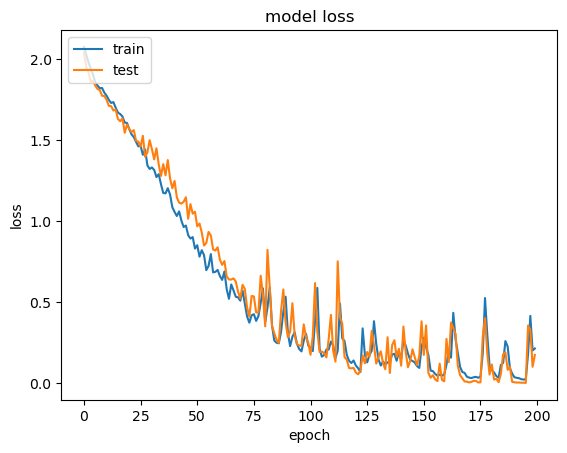

In [20]:
#sigmoid for getting input and tanh for output is used in lstm
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

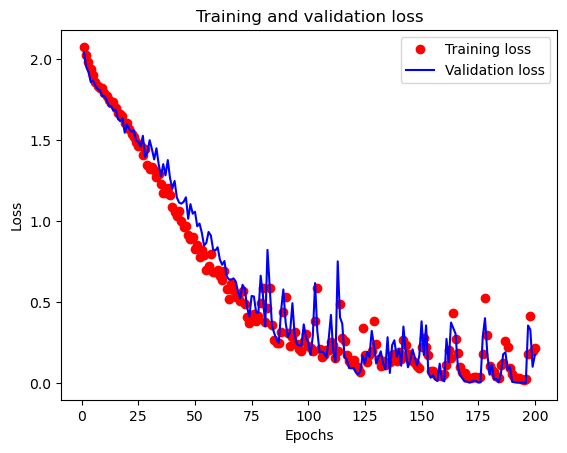

In [21]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

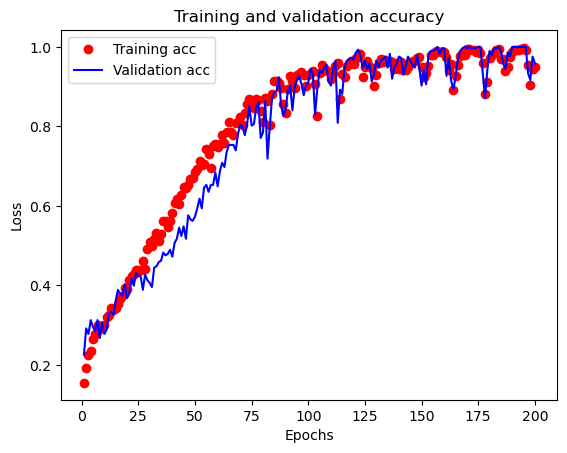

In [22]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
### evaluate using model A
evaluation_result = model_A.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], -1), labels_categorical[training_samples + validation_samples:])
accuracy = evaluation_result[1]  #metrix at 1
print("Accuracy:", accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9798 - loss: 0.0905 
Accuracy: 0.9861111044883728


In [24]:
emotions={1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 : 'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}
def predict(wav_filepath):
  test_point=extract_mfcc(wav_filepath)
  test_point=np.reshape(test_point,newshape=(1,40,1))
  predictions=model_A.predict(test_point)
  print(emotions[np.argmax(predictions[0])+1])

In [25]:
predict('ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
neutral


In [26]:
predict('ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-02-01.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
surprised


In [27]:
model_A.save('mymodel.h5')

In [28]:
import tensorflow as tf

modelc=tf.keras.models.load_model('mymodel.h5')

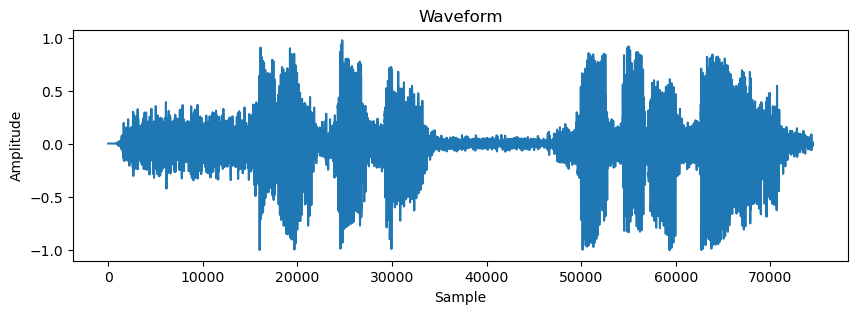

In [29]:
###Live audio waveplot
import librosa
import matplotlib.pyplot as plt

# Specify the audio file path
audio_file = 'Teja.opus'

# Load audio data
data, sampling_rate = librosa.load(audio_file)

# Create the plot
plt.figure(figsize=(10, 3))
plt.plot(data)  # Plot the waveform

# Add labels and title
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')


# Display the plot
plt.show()


In [30]:
predict('Teja.opus')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
neutral


In [31]:
predict('output.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
calm
